# **ML Model: Predict Heart Disease**

## Objectives

* Fit and evaluate a regression model to predict the Sale Price of a house.

## Inputs

* outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train Set (Features and Target)
* Test Set (Features and Target)
* Data Cleaning and Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Additional Comments

In this Notebook we will follow four step to manage achieve our objective:

* Step 1: Load Data
* Step 2: ML Pipeline with all data
* Step 3: Refit pipeline with best features
* Step 4: Push files to Repo



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5'

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Cardiovascular_Disease_Dataset.csv")
)

print(df.shape)
df.head()

(1000, 14)


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


---

## ML Pipeline with all data

### ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Data Cleaning
        ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['serumcholestrol'])), 

        # Feature Engineer
        ("YeoJohnsonTransformer",vt.YeoJohnsonTransformer(variables = ['maxheartrate','serumcholestrol','oldpeak'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                            method="spearman", threshold=0.1, selection_method="variance"))
    ])

    return pipeline_base

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 13) (800,) (200, 13) (200,)


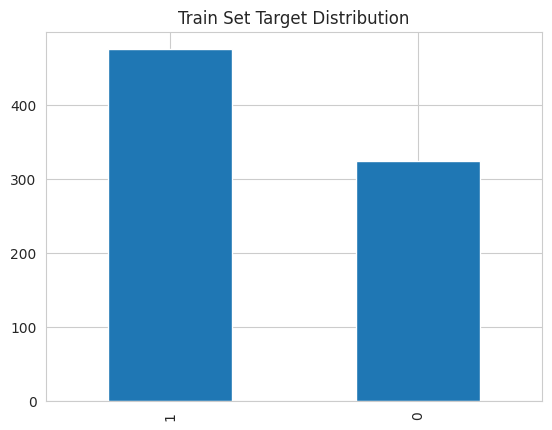

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

---

### Grid Search CV - Sklearn

We will optimize the search using default hyperparameter.

In [10]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {}
}

Quick GridSearch CV - Binary Classifier

In [11]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check the results:

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
5,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842
0,LogisticRegression,0.947368,0.966316,1.0,0.019295
6,AdaBoostClassifier,0.926316,0.962105,0.978947,0.019523
3,RandomForestClassifier,0.947368,0.957895,0.968421,0.009415
4,GradientBoostingClassifier,0.852632,0.915789,0.957895,0.047544
2,DecisionTreeClassifier,0.863158,0.913684,0.936842,0.02777
1,XGBClassifier,0.852632,0.875789,0.894737,0.016842


### Extensive Hyperparameter Search

In [16]:
models_search = {
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
}

params_search = {
    "ExtraTreesClassifier": {
        'model__n_estimators' : [50, 150, 500],
        'model__criterion' : ['gini', 'entropy'],
        'model__max_features' : ['sqrt', 'log2']
    }
}


Extensive GridSearch CV - Binary Classifier

In [17]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__criterion,model__max_features,model__n_estimators
1,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,gini,sqrt,150
2,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,gini,sqrt,500
4,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,gini,log2,150
5,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,gini,log2,500
8,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,entropy,sqrt,500
11,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,entropy,log2,500
6,ExtraTreesClassifier,0.947368,0.968421,0.989474,0.014886,entropy,sqrt,50
7,ExtraTreesClassifier,0.947368,0.968421,0.989474,0.014886,entropy,sqrt,150
9,ExtraTreesClassifier,0.947368,0.968421,0.989474,0.014886,entropy,log2,50
10,ExtraTreesClassifier,0.947368,0.968421,0.989474,0.014886,entropy,log2,150


In [19]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__criterion': 'gini',
 'model__max_features': 'sqrt',
 'model__n_estimators': 150}

Define the best clf pipeline

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_features='sqrt', n_estimators=150,
                                      random_state=0))])

### Assess feature importance

In [22]:
X_train.head(3)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels
687,6981961,57,0,0,180,517,0,1,191,0,1.9,3,3
500,4956428,58,0,0,135,201,0,1,190,1,1.8,1,0
332,3245660,21,0,0,139,213,0,1,71,1,2.3,1,1


With the current model, we can assess with .features_importances_

* These are the 4 most important features in descending order. The model was trained on them: 
['slope', 'restingBP', 'chestpain', 'noofmajorvessels']


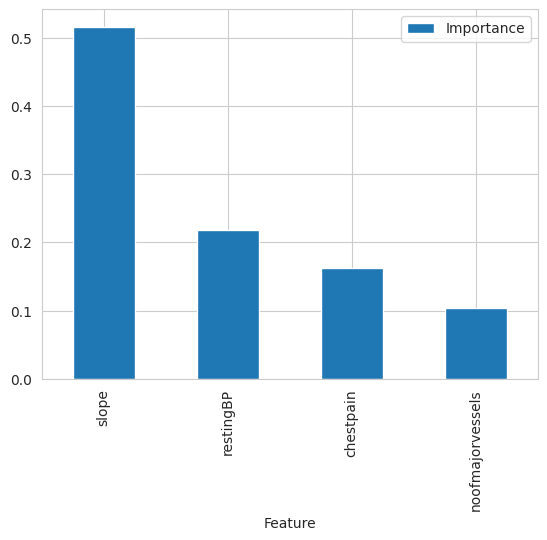

In [23]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case

98% Recall for presence Heart Disease, on train and test set
96% test set Accuracy 

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['no HD', 'HD' ] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn             325            6
Prediction Churn                  0          469


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.98      1.00      0.99       325
       Churn       1.00      0.99      0.99       475

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn              91            2
Prediction Churn                  4          103


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.98      0.96      0.97        95
       Churn       0.96      0.98      0.97       105

    accuracy                           0.97      

---

## Refit pipeline with best features

### Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [26]:
best_features

['slope', 'restingBP', 'chestpain', 'noofmajorvessels']

New Pipeline for DataCleaning And FeatureEngineering

In [27]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['serumcholestrol'])), 


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base

### Rewrite ML Pipeline for Modelling

In [28]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base

Split Train Test Set, considering only with best features

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 13) (800,) (200, 13) (200,)


We filter only the most important variables

In [31]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(800, 4) (800,) (200, 4) (200,)


,slope,restingBP,chestpain,noofmajorvessels
687,3,180,0,3
500,1,135,0,0
332,1,139,0,1


### Grid Search CV: Sklearn

In [33]:
models_search   # ExtraTreesClassifier

{'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)}

And the best parameters from the last GridCV search

In [34]:
best_parameters

{'model__criterion': 'gini',
 'model__max_features': 'sqrt',
 'model__n_estimators': 150}

We will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [37]:
params_search = {'ExtraTreesClassifier':  {
    'model__criterion': ['gini'],   # the value should be in []
    'model__max_features': ['sqrt'],  # the value should be in []
    'model__n_estimators': [150],}
}
params_search

{'ExtraTreesClassifier': {'model__criterion': ['gini'],
  'model__max_features': ['sqrt'],
  'model__n_estimators': [150]}}

GridSearch CV

In [38]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [39]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__criterion,model__max_features,model__n_estimators
0,ExtraTreesClassifier,0.947368,0.970526,0.989474,0.016842,gini,sqrt,150


Define the best clf pipeline

In [40]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(max_features='sqrt', n_estimators=150,
                                      random_state=0))])

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
